# Elaborazione delle Bioimmagini — Notebook (Capitolo 1)

Questo notebook riassume e mette in pratica i concetti del **Capitolo I: Modello dell'immagine biomedica e misure di qualità** con esempi numerici e simulazioni su immagini sintetiche.

**Contenuti principali:** modello dell’immagine biomedica, istogramma ed entropia, SNR/CNR, JND, profili e PVE/PSF.


## Setup
Esegui questa cella per importare le librerie necessarie.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Per filtri (smoothing gaussiano) usiamo scipy se disponibile.
try:
    from scipy.ndimage import gaussian_filter
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False
    gaussian_filter = None

def shannon_entropy(img: np.ndarray, bins: int = 256) -> float:
    """Entropia di Shannon calcolata dall'istogramma normalizzato."""
    x = img.ravel().astype(np.float64)
    hist, _ = np.histogram(x, bins=bins, density=False)
    p = hist / hist.sum()
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())

def add_gaussian_noise(img: np.ndarray, sigma: float, seed: int = 0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    return img + rng.normal(0.0, sigma, size=img.shape)

print('SciPy disponibile:', _HAS_SCIPY)


SciPy disponibile: True


## 1) Modello dell’immagine biomedica (idea)
Un'immagine biomedica ideale può essere vista come un insieme di regioni (tessuti) non sovrapposte, ciascuna con un livello di grigio caratteristico.
L’immagine reale osservata si discosta dall’ideale per effetto di:
- **rumore biologico** (non omogeneità intrinseche dei tessuti),
- **partial volume effect (PVE)** (smoothing ai bordi),
- **attenuazione / bias field** (variazioni lente moltiplicative),
- **rumore di acquisizione** (dipendente dalla fisica: es. MRI spesso Rician).

Nel seguito simuliamo questi effetti su un *phantom* semplice.


## 2) Phantom sintetico e istogramma
Creiamo una immagine con **tre regioni** (tre 'tessuti') e osserviamo istogramma ed entropia.


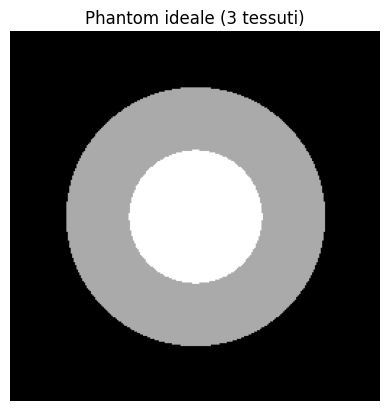

Entropia (ideale): 1.2822116103747303


In [2]:
def make_three_tissue_phantom(n=256, s1=50, s2=150, s3=200):
    img = np.full((n, n), s1, dtype=np.float64)
    yy, xx = np.mgrid[0:n, 0:n]
    r1 = (xx - n/2)**2 + (yy - n/2)**2 <= (n*0.35)**2
    r2 = (xx - n/2)**2 + (yy - n/2)**2 <= (n*0.18)**2
    img[r1] = s2
    img[r2] = s3
    return img

img0 = make_three_tissue_phantom()

plt.figure()
plt.imshow(img0, cmap='gray')
plt.title('Phantom ideale (3 tessuti)')
plt.axis('off')
plt.show()

H0 = shannon_entropy(img0, bins=256)
print('Entropia (ideale):', H0)


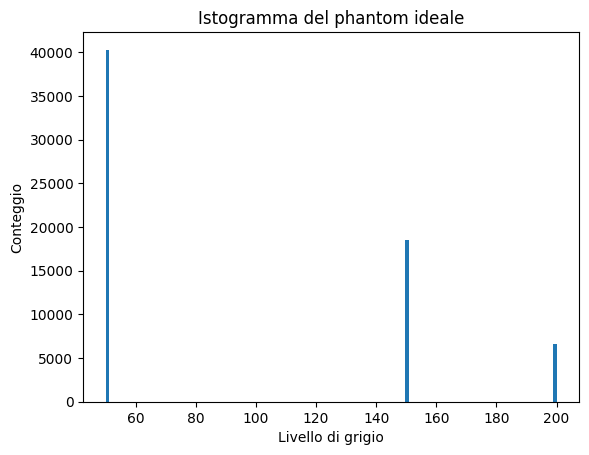

In [3]:
def plot_hist(img, bins=256, title='Istogramma'):
    plt.figure()
    plt.hist(img.ravel(), bins=bins)
    plt.title(title)
    plt.xlabel('Livello di grigio')
    plt.ylabel('Conteggio')
    plt.show()

plot_hist(img0, bins=128, title='Istogramma del phantom ideale')


## 3) Simulazione PVE (smoothing) e rumore
Il PVE può essere modellato come una **convoluzione** (spesso approssimata con un filtro gaussiano), che smussa i bordi.
Aggiungiamo poi rumore gaussiano come esempio semplice.


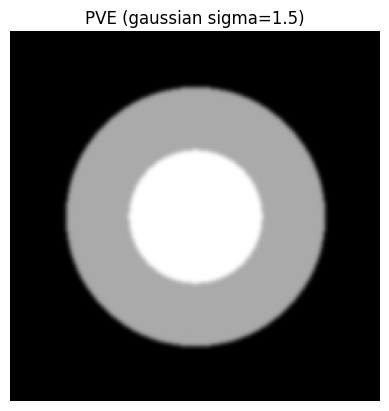

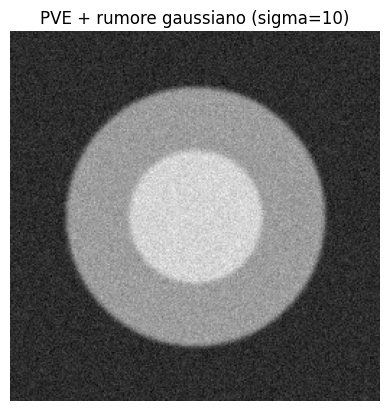

Entropia (PVE): 2.2742998018761615
Entropia (PVE+rumore): 6.937885227021427


In [4]:
sigma_pve = 1.5
if not _HAS_SCIPY:
    raise RuntimeError('Per questa sezione serve SciPy (scipy.ndimage.gaussian_filter).')

img_pve = gaussian_filter(img0, sigma=sigma_pve)
img_noisy = add_gaussian_noise(img_pve, sigma=10, seed=1)

plt.figure(); plt.imshow(img_pve, cmap='gray'); plt.title(f'PVE (gaussian sigma={sigma_pve})'); plt.axis('off'); plt.show()
plt.figure(); plt.imshow(img_noisy, cmap='gray'); plt.title('PVE + rumore gaussiano (sigma=10)'); plt.axis('off'); plt.show()

print('Entropia (PVE):', shannon_entropy(img_pve, bins=256))
print('Entropia (PVE+rumore):', shannon_entropy(img_noisy, bins=256))


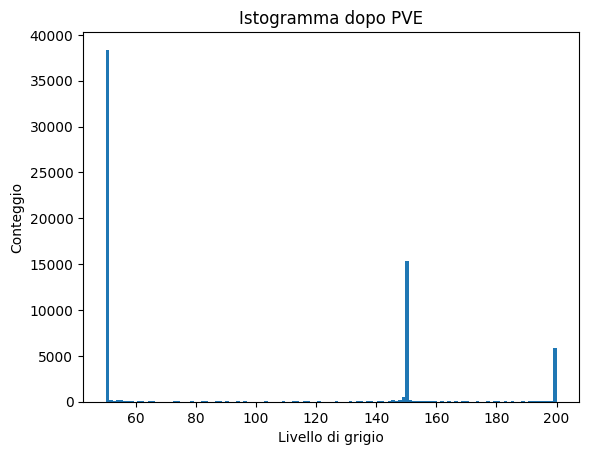

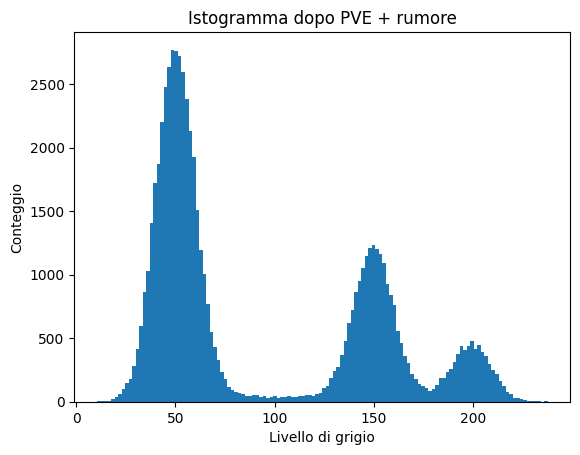

In [5]:
plot_hist(img_pve, bins=128, title='Istogramma dopo PVE')
plot_hist(img_noisy, bins=128, title='Istogramma dopo PVE + rumore')


## 4) SNR e CNR (da ROI)
Definizioni usate comunemente:
- **SNR** = media(segnale in ROI) / SD(rumore)
- **CNR** = |media(ROI1) − media(ROI2)| / media(SD nelle ROI)

Qui stimiamo media e deviazione standard da **ROI** circolari sul phantom.


ROI central (tessuto 3): mean, sd, n = (199.6438699902116, 9.947132500578842, 2965)  -> SNR = 20.070494685638696
ROI anello   (tessuto 2): mean, sd, n = (164.00778031038132, 23.697396231709362, 13176)  -> SNR = 6.920919864222187
ROI bg       (tessuto 1): mean, sd, n = (49.84207944467113, 9.906218022690126, 1313)
CNR (tessuto 2 vs 3) = 2.11838839909984


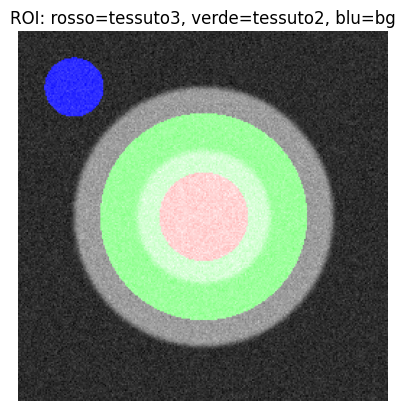

In [6]:
def circular_roi(n, cx, cy, r):
    yy, xx = np.mgrid[0:n, 0:n]
    return (xx - cx)**2 + (yy - cy)**2 <= r**2

n = img_noisy.shape[0]
roi_inner = circular_roi(n, n/2, n/2, n*0.12)   # tessuto centrale (s3)
roi_mid   = circular_roi(n, n/2, n/2, n*0.28) & (~roi_inner)  # anello (s2)
roi_bg    = circular_roi(n, n*0.15, n*0.15, n*0.08)  # background (s1) in alto a sinistra

def roi_stats(img, mask):
    vals = img[mask]
    return float(vals.mean()), float(vals.std(ddof=1)), int(vals.size)

m3, sd3, k3 = roi_stats(img_noisy, roi_inner)
m2, sd2, k2 = roi_stats(img_noisy, roi_mid)
m1, sd1, k1 = roi_stats(img_noisy, roi_bg)

snr_3 = m3 / sd3
snr_2 = m2 / sd2
cnr_23 = abs(m2 - m3) / ((sd2 + sd3)/2)

print('ROI central (tessuto 3): mean, sd, n =', (m3, sd3, k3), ' -> SNR =', snr_3)
print('ROI anello   (tessuto 2): mean, sd, n =', (m2, sd2, k2), ' -> SNR =', snr_2)
print('ROI bg       (tessuto 1): mean, sd, n =', (m1, sd1, k1))
print('CNR (tessuto 2 vs 3) =', cnr_23)

# Visualizziamo le ROI
overlay = np.zeros((*img_noisy.shape, 3), dtype=np.float64)
norm = (img_noisy - img_noisy.min()) / (img_noisy.max() - img_noisy.min() + 1e-12)
overlay[..., 0] = norm
overlay[..., 1] = norm
overlay[..., 2] = norm
overlay[roi_inner, 0] = 1  # rosso
overlay[roi_mid, 1] = 1    # verde
overlay[roi_bg, 2] = 1     # blu

plt.figure(); plt.imshow(overlay); plt.title('ROI: rosso=tessuto3, verde=tessuto2, blu=bg'); plt.axis('off'); plt.show()


### Nota su MRI (rumore Rician)
Nelle **immagini di modulo MRI**, il rumore non è additivo puro (spesso segue una distribuzione Rician).
Per stime corrette di SNR/CNR da sfondo, servono correzioni che dipendono dal tipo di bobina e dalla ricostruzione.


## 5) JND (Just Noticeable Difference)
Un indicatore semplice è:

**JND = (F − B) / B**

dove **B** è il segnale di sfondo e **F** il segnale dell’oggetto.
Qui facciamo una stima sul phantom (centrale vs background).


In [7]:
B = m1
F = m3
jnd = (F - B) / B
print('JND stimato (tessuto3 vs background) =', jnd)


JND stimato (tessuto3 vs background) = 3.0055285055237912


## 6) Profili, acutezza e PVE
Un modo pratico per valutare lo smoothing dei bordi è estrarre un **profilo** di intensità lungo una direzione.
Nel caso ideale la transizione è un gradino; col PVE la transizione si allarga.


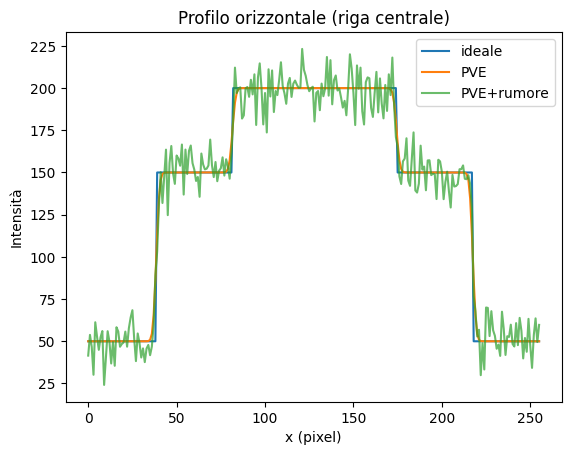

In [8]:
row = img0.shape[0]//2
prof_ideal = img0[row, :]
prof_pve = img_pve[row, :]
prof_noisy = img_noisy[row, :]

plt.figure()
plt.plot(prof_ideal, label='ideale')
plt.plot(prof_pve, label='PVE')
plt.plot(prof_noisy, label='PVE+rumore', alpha=0.7)
plt.title('Profilo orizzontale (riga centrale)')
plt.xlabel('x (pixel)')
plt.ylabel('Intensità')
plt.legend()
plt.show()


In [9]:
def transition_width(profile, low, high):
    """Stima larghezza transizione come distanza tra crossing al 10% e 90% del gradino."""
    p = np.asarray(profile)
    lo = low + 0.1*(high-low)
    hi = low + 0.9*(high-low)
    idx = np.arange(p.size)
    # crossing: primo indice dove p supera la soglia
    def first_cross(th):
        w = np.where(p >= th)[0]
        return int(w[0]) if w.size else None
    a = first_cross(lo)
    b = first_cross(hi)
    if a is None or b is None:
        return None
    return b - a

# Consideriamo la transizione bg->tessuto2 sulla metà sinistra del profilo
low = np.median(prof_ideal[:50])
high = np.median(prof_ideal[100:150])
w_pve = transition_width(prof_pve, low, high)
w_noisy = transition_width(prof_noisy, low, high)

print('Larghezza transizione (10%-90%) su PVE:', w_pve, 'pixel')
print('Larghezza transizione (10%-90%) su PVE+rumore:', w_noisy, 'pixel')


Larghezza transizione (10%-90%) su PVE: 46 pixel
Larghezza transizione (10%-90%) su PVE+rumore: 58 pixel


### PSF (Point Spread Function)
Se il sistema fosse LSI (lineare e invariante nello spazio), l'immagine osservata può essere vista come una **convoluzione** con la PSF.
Una PSF gaussiana è un modello comune; sotto mostriamo la PSF 2D e un profilo 1D.


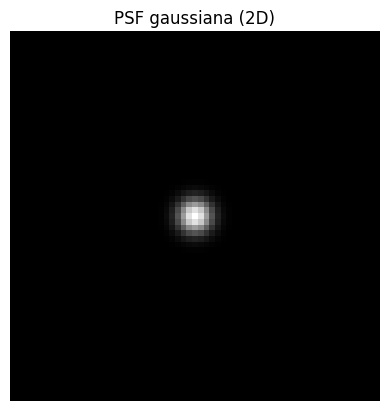

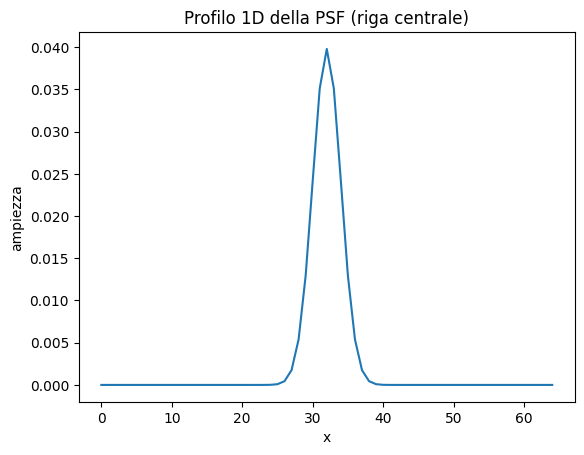

In [10]:
def gaussian_psf(n=65, sigma=2.0):
    ax = np.arange(-(n//2), n//2 + 1)
    yy, xx = np.meshgrid(ax, ax)
    psf = np.exp(-(xx**2 + yy**2)/(2*sigma**2))
    psf /= psf.sum()
    return psf

psf = gaussian_psf(sigma=2.0)

plt.figure(); plt.imshow(psf, cmap='gray'); plt.title('PSF gaussiana (2D)'); plt.axis('off'); plt.show()
plt.figure(); plt.plot(psf[psf.shape[0]//2, :]); plt.title('Profilo 1D della PSF (riga centrale)'); plt.xlabel('x'); plt.ylabel('ampiezza'); plt.show()


## 7) (Opzionale) Lettura di DICOM e metadati
Se vuoi collegare questi concetti a dati reali, puoi leggere file DICOM e ispezionare campi come:
- Rows/Columns, Bits Allocated, Pixel Spacing,
- Slice Thickness, Image Position Patient, Image Orientation Patient,
- Trigger Time, ecc.

Esempio (decommenta se hai un DICOM a disposizione):


In [ ]:
# !pip -q install pydicom
# import pydicom
# from pathlib import Path
#
# dicom_path = Path('path/al/tuo/file.dcm')
# ds = pydicom.dcmread(dicom_path)
# print('Rows:', ds.Rows, 'Columns:', ds.Columns)
# print('BitsAllocated:', ds.BitsAllocated)
# print('PixelSpacing:', getattr(ds, 'PixelSpacing', None))
# print('SliceThickness:', getattr(ds, 'SliceThickness', None))
#
# img = ds.pixel_array.astype(np.float64)
# plt.figure(); plt.imshow(img, cmap='gray'); plt.title('DICOM'); plt.axis('off'); plt.show()
